In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
import os
import torch
import importlib

In [81]:
sys.path.append('../src/porbnet')
import networks_porbnet
import util_porbnet
np.random.seed(0)
torch.manual_seed(0)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [82]:
def plot_prior_predictive(x_pred, f_pred, upcross_level=0, bins=20, plot_all_functions=False,n_func_plot=None):
    '''
    x_pred: (n_gridpoints,) numpy array
    f_pred: (n_samples, n_gridpoints) numpy array of function samples
    '''
    f_pred_mean = np.mean(f_pred,0)
    f_pred_std = np.std(f_pred,0)

    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,4))

    # amp. variance
    #ax[0].plot(x_pred, f_pred_mean)
    #ax[0].fill_between(x_pred.ravel(), f_pred_mean-f_pred_std, f_pred_mean+f_pred_std, alpha=.5)
    ax[0].set_title('amplitude variance')
    
    ax[0].plot(x_pred.ravel(), f_pred_mean-f_pred_std, ':k')
    ax[0].plot(x_pred.ravel(), f_pred_mean+f_pred_std, ':k', label=r'$\mathbb{V}\ [f(x)]$')

        
    if plot_all_functions:
        idx_plot = np.random.choice(f_pred.shape[0], n_func_plot, replace=False)
        ax[0].plot(x_pred, f_pred[idx_plot[0],:].T, alpha=.5, color='tab:red',linewidth=.5,label=r'$f(x)$')
        ax[0].plot(x_pred, f_pred[idx_plot[1:],:].T, alpha=.5, color='tab:red',linewidth=.5)

    # upcrossings
    u = upcross_level*np.ones(x_pred.shape[0])
    up = np.logical_and(f_pred[:,:-1]<u[:-1], f_pred[:,1:]>u[1:])
    idx_up = [np.where(row)[0] for row in up]
    x_up = x_pred.ravel()[np.concatenate(idx_up)]
    ax[1].hist(x_up, bins=bins, weights = 1/f_pred.shape[0]*np.ones(len(x_up)), color='tab:gray',rwidth=1.0,edgecolor='tab:gray')
    ax[1].set_title('upcrossings --- total = %.3f' % np.sum(up))
    
    return fig, ax

In [83]:
intensity_low = 2
intensity_high = 10
s2_0 = 4
T = [-2,2]
prior_b_sig2 = .5
prior_w_sig2 = .5

x_plot = np.linspace(-2,2,1000)

In [84]:
np.random.seed(2)
torch.manual_seed(2)

intensity_func = util_porbnet.Piecewise(np.array([T[0],0, T[1]]),np.array([intensity_low, intensity_high])) 

dim_hidden_initial = (T[1]-0)*intensity_high + (0-T[0])*intensity_low

net = networks_porbnet.RBFN(dim_in=1, dim_hidden_initial=dim_hidden_initial, \
                            dim_hidden_max=3*dim_hidden_initial, \
                            dim_out=1, intensity=intensity_func, s2_0=s2_0, \
                            prior_w_sig2 = prior_w_sig2*np.sqrt(np.pi/s2_0), prior_b_sig2 = prior_b_sig2, \
                            sig2 = .01)

torch.manual_seed(0)
f_samp = net.sample_functions_prior(torch.from_numpy(x_plot).reshape(-1,1), \
                                    n_samp=2000, sample_K=True, sample_intensity=False).detach().numpy()



Text(0.5, 0, '$x$')

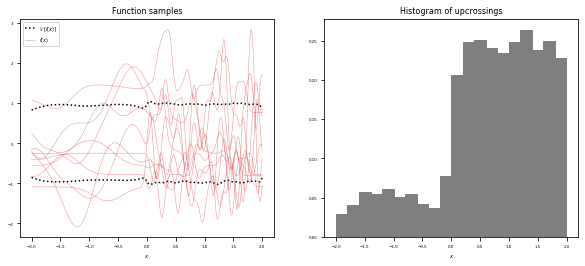

In [85]:
plt.rcParams.update({'font.size': 4})
plt.rcParams.update({'legend.fontsize': 5})
plt.rcParams.update({'axes.labelsize': 5})
plt.rcParams.update({'axes.titlesize': 8})

fig, ax = plot_prior_predictive(x_plot, \
                                f_samp, \
                                upcross_level=0, \
                                bins=20, \
                                plot_all_functions=True,
                                n_func_plot=10)


ax[0].set_title('Function samples')
ax[1].set_title('Histogram of upcrossings')
ax[0].legend()
ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$x$')



In [86]:
fig.set_size_inches(3.33, 1.5)
fig.tight_layout()

In [88]:
fig.savefig('upcross_illustration.pdf',bbox_inches='tight', pad_inches=.01)
fig.savefig('upcross_illustration.png',bbox_inches='tight', pad_inches=.01)